In [1]:
import pandas as pd
import numpy as np

import warnings
# Code was showing some warnings, from stack overflow optimal answer was to include this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df= pd.read_csv("fetal_health.csv")

In [3]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]   


## Splitting & Using XGB


In [5]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

xgb_classifier = xgb.XGBClassifier()

start_time = time.time()
xgb_classifier.fit(X_train, y_train_encoded)
end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time} seconds")

y_pred_encoded = xgb_classifier.predict(X_test)

y_pred = le.inverse_transform(y_pred_encoded)


Training time: 0.1158909797668457 seconds


## Using Evaluation Metrics

Accuracy =  96.0093896713615 %
Precision =  0.9328522070457553
Recall =  0.9451169919919921
F1-score =  0.9385528385528384


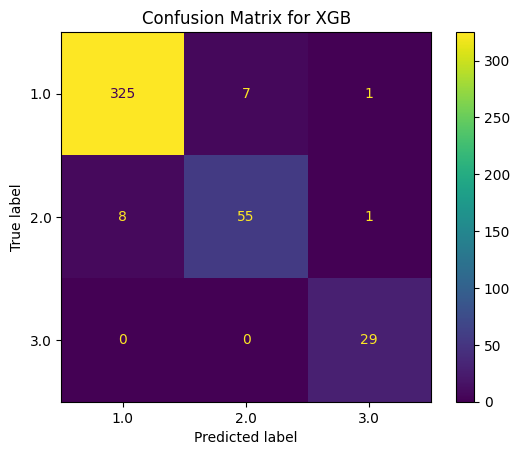

Classification Report
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98       333
         2.0       0.89      0.86      0.87        64
         3.0       0.94      1.00      0.97        29

    accuracy                           0.96       426
   macro avg       0.93      0.95      0.94       426
weighted avg       0.96      0.96      0.96       426



In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Calculating using average macro
print("Accuracy = ", accuracy_score(y_test, y_pred) * 100, "%")
print("Precision = ", precision_score(y_test, y_pred,average='macro'))
print("Recall = ", recall_score(y_test, y_pred,average='macro'))
print("F1-score = ", f1_score(y_test, y_pred,average='macro'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for XGB')
plt.show()

print("Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

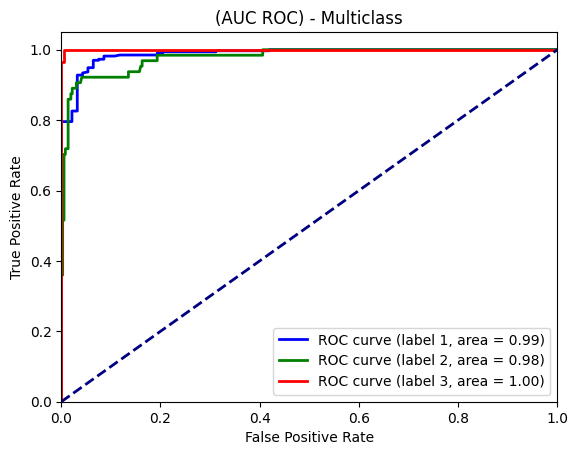

In [7]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = xgb_classifier.predict_proba(X_test)

plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


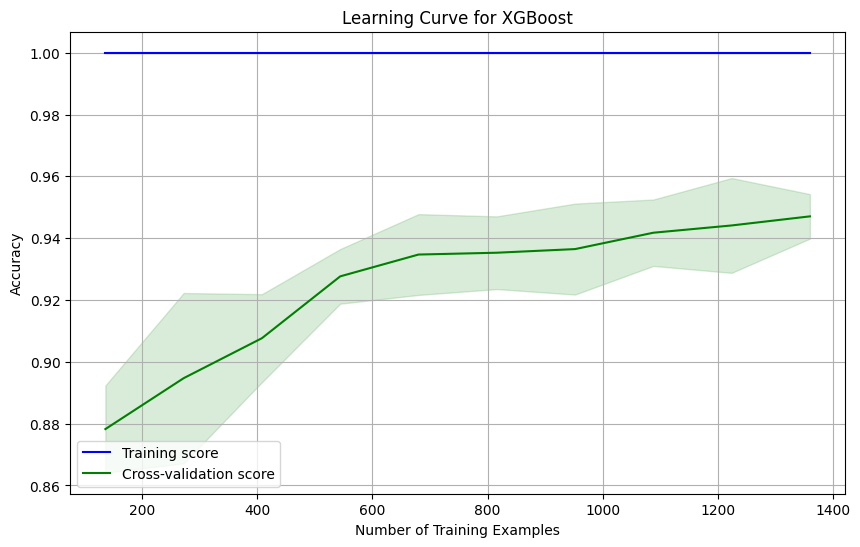

In [8]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_classifier, X_train, y_train_encoded, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

plt.title('Learning Curve for XGBoost')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


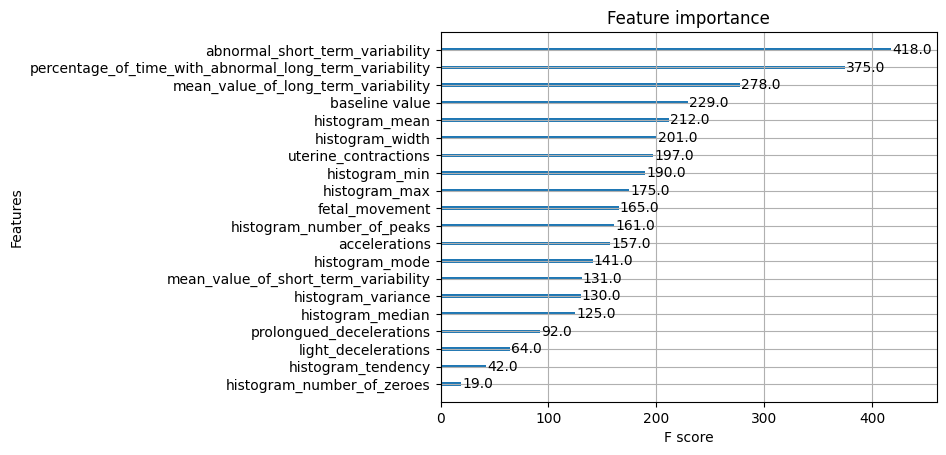

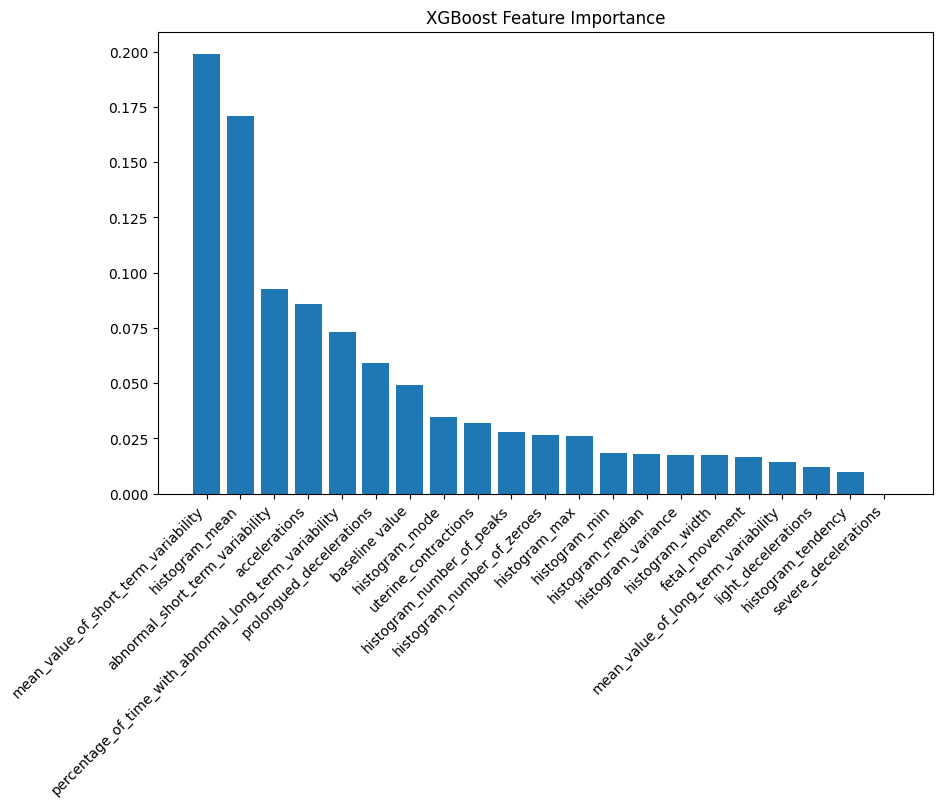

In [9]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb_classifier.fit(X_train, y_train_encoded)

xgb.plot_importance(xgb_classifier)
plt.show()

feature_importance = xgb_classifier.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

# print("Feature importance:")
# for idx in sorted_idx:
#     print(f"{X.columns[idx]}: {feature_importance[idx]}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_importance)), X.columns[sorted_idx], rotation=45, ha="right")
plt.title("XGBoost Feature Importance")
plt.show()


In [10]:
top_k_features_indices = sorted_idx[:12]
print("Indices of Important Features:", top_k_features_indices)

X_selected = X.iloc[:, top_k_features_indices]

Indices of Important Features: [ 8 17  7  1  9  6  0 16  3 14 15 13]


## Checking class distribution

Class Distribution:
fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64
Coefficient of Variation (CV): 1.1595095195631708


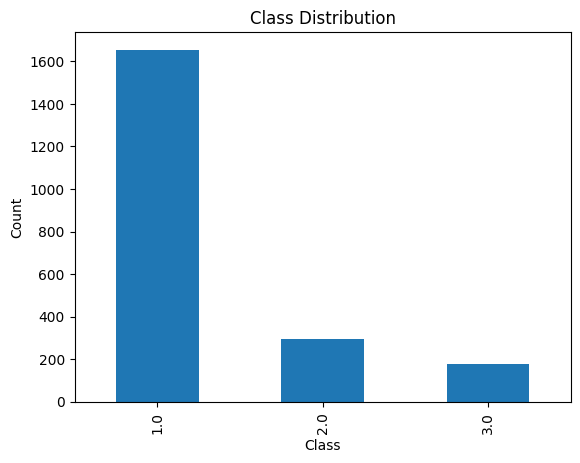

In [11]:

target_column = 'fetal_health'

class_distribution = df[target_column].value_counts()

mean_class_size = class_distribution.mean()
std_class_size = class_distribution.std()
imbalance_cv = std_class_size / mean_class_size

print(f"Class Distribution:\n{class_distribution}")
print(f"Coefficient of Variation (CV): {imbalance_cv}")

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Applying SMOTE


In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


print("Feature names during training:", X_resampled.columns)
print("Feature names in the test set:", X_test.columns)
X_test_aligned = X_test[X_resampled.columns]

Feature names during training: Index(['mean_value_of_short_term_variability', 'histogram_mean',
       'abnormal_short_term_variability', 'accelerations',
       'percentage_of_time_with_abnormal_long_term_variability',
       'prolongued_decelerations', 'baseline value', 'histogram_mode',
       'uterine_contractions', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_max'],
      dtype='object')
Feature names in the test set: Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histo

Class Distribution:
fetal_health
2.0    1655
1.0    1655
3.0    1655
Name: count, dtype: int64
Coefficient of Variation (CV): 0.0


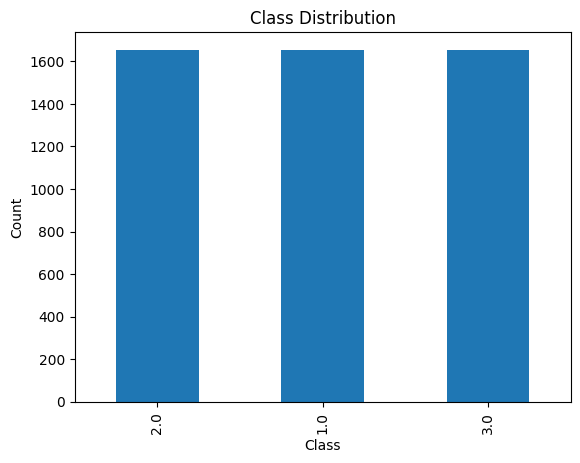

In [13]:


class_distribution = y_resampled.value_counts()

mean_class_size = class_distribution.mean()
std_class_size = class_distribution.std()
imbalance_cv = std_class_size / mean_class_size

print(f"Class Distribution:\n{class_distribution}")
print(f"Coefficient of Variation (CV): {imbalance_cv}")

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Using XGB

In [14]:
le = LabelEncoder()
y_resampled_encoded = le.fit_transform(y_resampled)

xgb_classifier_after = xgb.XGBClassifier()
xgb_classifier_after.fit(X_resampled, y_resampled_encoded)

# y_pred_encoded = xgb_classifier_after.predict(X_test)

y_pred_after = le.inverse_transform(y_pred_encoded)
y_pred_full = xgb_classifier_after.predict(X_resampled)
y_pred_test = xgb_classifier_after.predict(X_test_aligned)

y_test_converted = y_test - 1
y_train_converted = y_train - 1


Holdout CV : 0.9254754246685681
k-Fold CV : 0.9792551459072147
Stratified k-Fold CV: 0.9826780192587922


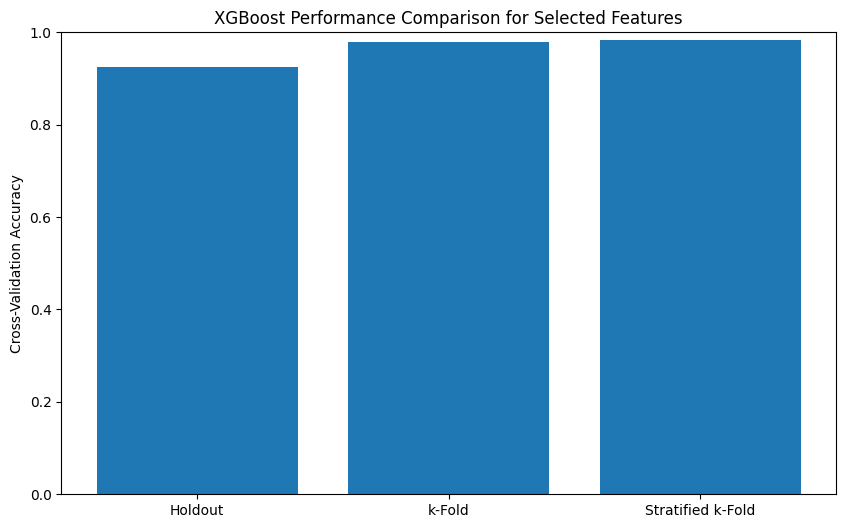

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold,LeaveOneOut
from xgboost import XGBClassifier

cv_scores_holdout = []
cv_scores_kfold = []
cv_scores_stratified_kfold = []
cv_scores_leave_one_out = []


scores_holdout = cross_val_score(xgb_classifier, X_resampled, y_resampled_encoded, cv=2, scoring='accuracy')
cv_scores_holdout.append(scores_holdout.mean())
print(f'Holdout CV : {scores_holdout.mean()}')

kf = KFold(n_splits=4, shuffle=True, random_state=42)
scores_kfold = cross_val_score(xgb_classifier, X_resampled,y_resampled_encoded, cv=kf, scoring='accuracy')
cv_scores_kfold.append(scores_kfold.mean())
print(f'k-Fold CV : {scores_kfold.mean()}')

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scores_stratified_kfold = cross_val_score(xgb_classifier, X_resampled, y_resampled_encoded, cv=skf, scoring='accuracy')
cv_scores_stratified_kfold.append(scores_stratified_kfold.mean())
print(f'Stratified k-Fold CV: {scores_stratified_kfold.mean()}')

# loo = LeaveOneOut()
# scores_leave_one_out = cross_val_score(xgb_classifier, X_resampled, y_resampled_encoded, cv=loo, scoring='accuracy')
# cv_scores_leave_one_out.append(scores_leave_one_out.mean())

labels = ['Holdout', 'k-Fold', 'Stratified k-Fold']
scores = [cv_scores_holdout[0], cv_scores_kfold[0], cv_scores_stratified_kfold[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels, scores)
plt.title('XGBoost Performance Comparison for Selected Features')
plt.ylabel('Cross-Validation Accuracy')
plt.ylim([0, 1])
plt.show()


## Using Evaluation Metrics

Accuracy (Resampled): 99.95971802618328 %
Precision (macro, Resampled): 0.999597180261833
Recall (macro, Resampled): 0.999597180261833
F1-score (macro, Resampled): 0.999597180261833
Confusion Matrix (Resampled):


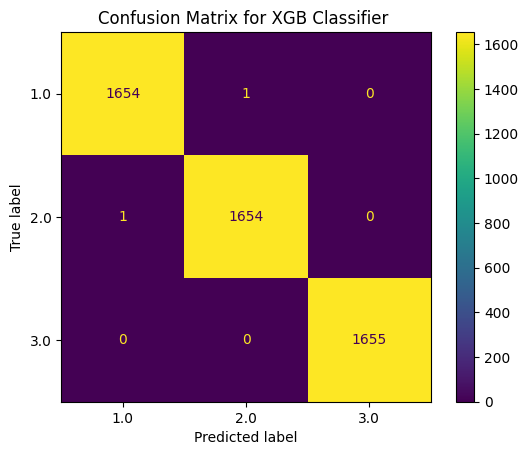

Classification Report (Resampled):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1655
           1       1.00      1.00      1.00      1655
           2       1.00      1.00      1.00      1655

    accuracy                           1.00      4965
   macro avg       1.00      1.00      1.00      4965
weighted avg       1.00      1.00      1.00      4965

Test Accuracy: 99.53051643192488 %
Test Precision (macro): 0.9937906656656658
Test Recall (macro): 0.9937906656656658
Test F1-score (macro): 0.9937906656656658


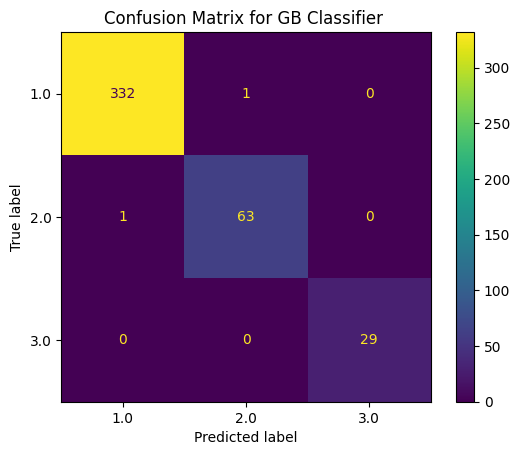

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

accuracy_resampled = accuracy_score(y_resampled_encoded, y_pred_full)
precision_resampled = precision_score(y_resampled_encoded, y_pred_full, average='macro')
recall_resampled = recall_score(y_resampled_encoded, y_pred_full, average='macro')
f1_resampled = f1_score(y_resampled_encoded, y_pred_full, average='macro')

conf_matrix_resampled = confusion_matrix(y_resampled_encoded, y_pred_full)
class_report_resampled = classification_report(y_resampled_encoded, y_pred_full)

print("Accuracy (Resampled):", accuracy_resampled * 100, "%")
print("Precision (macro, Resampled):", precision_resampled)
print("Recall (macro, Resampled):", recall_resampled)
print("F1-score (macro, Resampled):", f1_resampled)

print("Confusion Matrix (Resampled):")
conf_matrix = confusion_matrix(y_resampled_encoded, y_pred_full)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for XGB Classifier ')
plt.show()
print("Classification Report (Resampled):")
print(class_report_resampled)


test_accuracy = accuracy_score(y_test_converted, y_pred_test)
test_precision = precision_score(y_test_converted, y_pred_test, average='macro')
test_recall = recall_score(y_test_converted, y_pred_test, average='macro')
test_f1 = f1_score(y_test_converted, y_pred_test, average='macro')
test_conf_matrix = confusion_matrix(y_test_converted, y_pred_test)

print("Test Accuracy:", test_accuracy * 100, "%")
print("Test Precision (macro):", test_precision)
print("Test Recall (macro):", test_recall)
print("Test F1-score (macro):", test_f1)

conf_matrix = confusion_matrix(y_test_converted, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for XGB Classifier ')
plt.show()


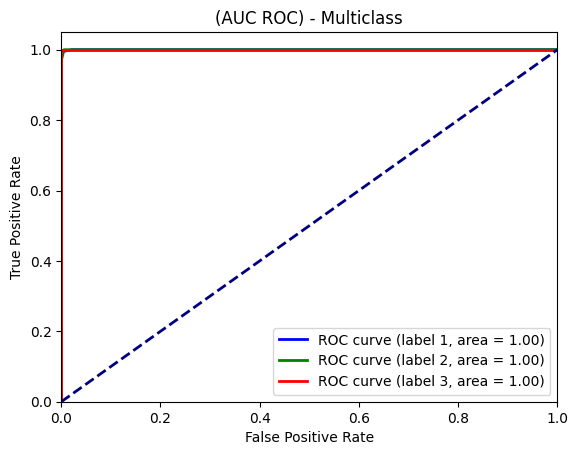

In [17]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = xgb_classifier_after.predict_proba(X_test_aligned)


plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


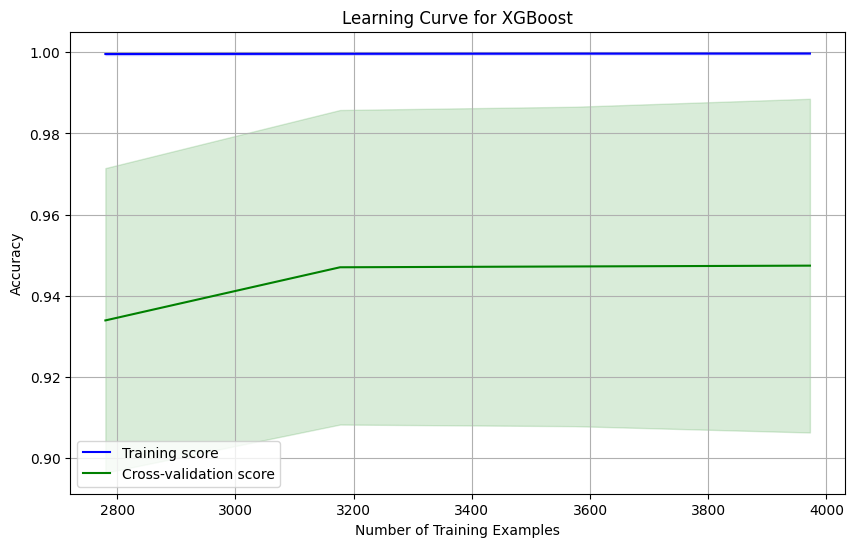

In [18]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_classifier_after, X_resampled, y_resampled_encoded, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

plt.title('Learning Curve for XGBoost')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


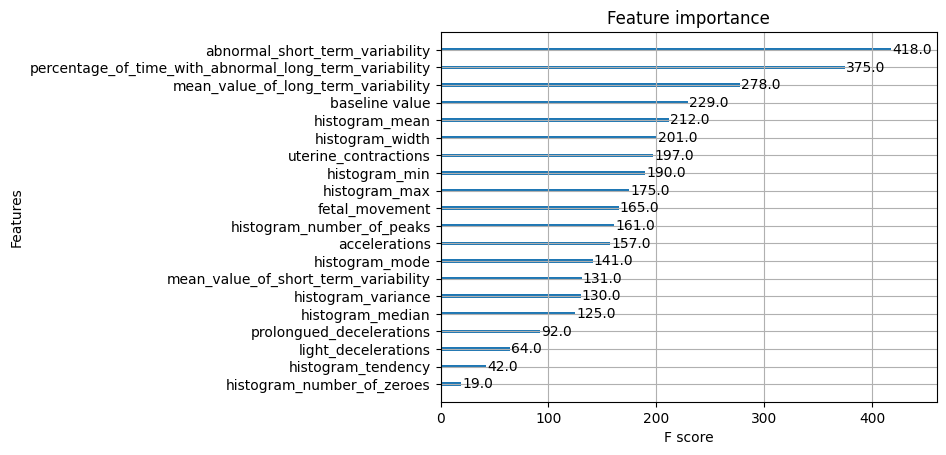

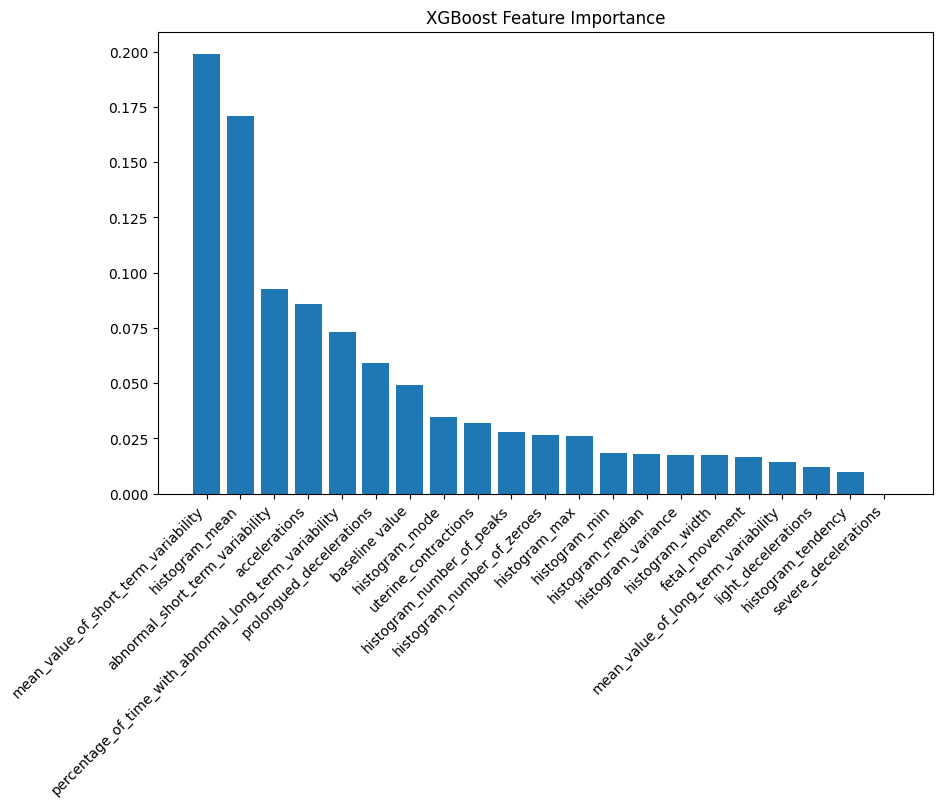

In [19]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb_classifier.fit(X_train, y_train_encoded)

xgb.plot_importance(xgb_classifier)
plt.show()

feature_importance = xgb_classifier.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

# print("Feature importance:")
# for idx in sorted_idx:
#     print(f"{X.columns[idx]}: {feature_importance[idx]}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_importance)), X.columns[sorted_idx], rotation=45, ha="right")
plt.title("XGBoost Feature Importance")
plt.show()
